# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

**Before starting with this lab, here is a quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating).**

## Data set

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [1]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2') as source:
    speeches_201718 = pd.read_json(source)

with bz2.open('speeches-201819.json.bz2') as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [2]:
speeches_201718.head(n=10)

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD
5,H5-003-005,herr talman jag inleder med att tacka vänsterp...,MP
6,H5-003-006,herr talman vi debatterar i dag situationen fö...,C
7,H5-003-007,herr talman runt om i landet på torg och i kla...,V
8,H5-003-008,aktuell debatt om situationen för ensamkommand...,L
9,H5-003-009,herr talman det råder ingen tvekan om att situ...,KD


Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [3]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [4]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

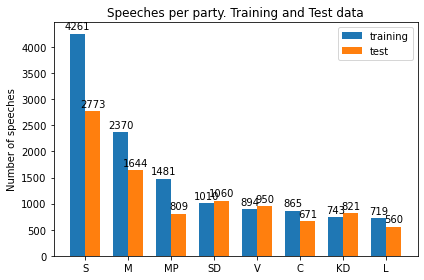



 In the training set 34% of values are S


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Count the speeches relative each party. Use a semi-sorted list of parties
count_training = training_data['party'].value_counts()
count_test = test_data['party'].value_counts()
sorted_parties = count_training.keys()

# Arrange the order to match the x-axis
training_sorted = [count_training[party] for party in sorted_parties]
test_sorted = [count_test[party] for party in sorted_parties]

# Create plot
x = np.arange(len(parties))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_sorted, width, label='training')
rects2 = ax.bar(x + width/2, test_sorted, width, label='test')

# Add some labels
ax.set_ylabel('Number of speeches')
ax.set_title('Speeches per party. Training and Test data')
ax.set_xticks(x)
ax.set_xticklabels(sorted_parties)
ax.legend()
ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)

# Show the plot
fig.tight_layout()
plt.show()

print("\n\n In the training set %d%% of values are S" % 
      (100 * float(count_training['S']) / count_training.sum()))


We notice that the data is unbalanced. The S class is overrepresented and this may cause problems when training the model, since the classifier could simply classify everything as S and, as such, get a fairly high score of 34% accuracy (on the training set).

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

In [6]:
# Preprocess words
stop_words = ['och', 'det', 'att', 'i', 'en', 'jag', 'hon', 'som', 'han', 'på', 'den', 'med', 'var', 'sig', 'för', 'så', 'till', 'är', 'men', 'ett', 'om', 'hade', 'de', 'av', 'icke', 'mig', 'du', 'henne', 'då', 'sin', 'nu', 'har', 'inte', 'hans', 'honom', 'skulle', 'hennes', 'där', 'min', 'man', 'ej', 'vid', 'kunde', 'något', 'från', 'ut', 'när', 'efter', 'upp', 'vi', 'dem', 'vara', 'vad', 'över', 'än', 'dig', 'kan', 'sina', 'här', 'ha', 'mot', 'alla', 'under', 'någon', 'eller', 'allt', 'mycket', 'sedan', 'ju', 'denna', 'själv', 'detta', 'åt', 'utan', 'varit', 'hur', 'ingen', 'mitt', 'ni', 'bli', 'blev', 'oss', 'din', 'dessa', 'några', 'deras', 'blir', 'mina', 'samma', 'vilken', 'er', 'sådan', 'vår', 'blivit', 'dess', 'inom', 'mellan', 'sådant', 'varför', 'varje', 'vilka', 'ditt', 'vem', 'vilket', 'sitta', 'sådana', 'vart', 'dina', 'vars', 'vårt', 'våra', 'ert', 'era', 'vilkas']
def preprocess(text):    
    return [token.lower() for token in text.split() if token.isalpha() and token.lower() not in stop_words]

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report

x_train = training_data['words']
y_train = training_data['party']
x_test = test_data['words']
y_test = test_data['party']

def train_and_print(binary=False, ngram_range=(1,1), alpha=1.0, train=[x_train, y_train]):  
    pipe = Pipeline(
        [('count_vect',CountVectorizer(binary=binary, ngram_range=ngram_range, tokenizer=preprocess)),
        ('nbClassifier',MultinomialNB(alpha=alpha))
        ]
    )
    pipe.fit(*train)
    prediction_test = pipe.predict(x_test)
    print(classification_report(y_test, prediction_test, target_names=parties))
    return prediction_test, pipe

# These global variables will be used again later.
prediction_test, pipe = train_and_print()

print('%s%% of predictions are S' % round(100 * (prediction_test == 'S').sum() / len(prediction_test)))


              precision    recall  f1-score   support

           C       0.63      0.06      0.10       671
          KD       0.72      0.03      0.05       821
           L       0.50      0.03      0.05       560
           M       0.37      0.67      0.48      1644
          MP       0.36      0.28      0.31       809
           S       0.47      0.83      0.60      2773
          SD       0.58      0.17      0.26      1060
           V       0.59      0.18      0.27       950

    accuracy                           0.44      9288
   macro avg       0.53      0.28      0.27      9288
weighted avg       0.50      0.44      0.36      9288

53% of predictions are S


Would you have expected the results that you got?
> Yes, somewhat. For example: the recall for the 'S' class is noticebly the highest score with 83%, and this is an expected consequence due to the dataset being overrepresented by that class. When the class prediction is uncertain the model will probably fall back on the S value and, as such, it is predicted 53% of the time and thus gets most of them right. However, this behaviour do not favour the precision score, and it significantly reduces the recall score from other classes, such as 'KD' and 'L' which only has a recall of 3%.

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [8]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
print('The accuracy for the random baseline is %d%%' % round(dummy_clf.score(x_test, y_test)*100))

The accuracy for the random baseline is 30%


An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [9]:
print('From problem 1 it can be determined that the most frequent class is S')
print("\nIn the training set %d%% of all documents are of class S" % 
      (100 * float(count_training['S']) / count_training.sum()))
print("In the test set %d%% of all documents are of class S" % 
      (100 * float(count_test['S']) / count_test.sum()))

From problem 1 it can be determined that the most frequent class is S

In the training set 34% of all documents are of class S
In the test set 29% of all documents are of class S


## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Summarise your results in a short text.

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [18]:
from random import shuffle

undersampled_parties = []
lowest_frequency = count_training[-1]
for i in parties:
    new_data = training_data[training_data.party==i]
    np.random.shuffle(np.array(new_data))
    undersampled_parties.append(new_data[:lowest_frequency])

undersampled_training = pd.concat(undersampled_parties)
print('# elements in the balanced subset: ', len(undersampled_training), end='\n\n') 

undersampled_train = undersampled_training['words'], undersampled_training['party']
undersampled_prediction_test, _ = train_and_print(train=undersampled_train)

print('%s%% of predictions are S' % round(100 * (undersampled_prediction_test == 'S')
                                          .sum() / len(undersampled_prediction_test)))

# elements in the balanced subset:  5752

              precision    recall  f1-score   support

           C       0.23      0.46      0.31       671
          KD       0.27      0.40      0.32       821
           L       0.24      0.46      0.32       560
           M       0.41      0.36      0.39      1644
          MP       0.33      0.36      0.35       809
           S       0.80      0.26      0.39      2773
          SD       0.40      0.43      0.42      1060
           V       0.39      0.55      0.45       950

    accuracy                           0.38      9288
   macro avg       0.39      0.41      0.37      9288
weighted avg       0.48      0.38      0.38      9288

10% of predictions are S


Accuracy is a bit less, but the recall is more equally distributed on the classes now. The most frequent classes, which were previously favoured by the model with good recall, now have the worst recall (but a better precision score). The occurence percentage of the predicted class 'S' went from 53% to 10%

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). If you would rather see a visual representation, you can also use [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

In [11]:
from sklearn.metrics import confusion_matrix
class Bold:
    START = '\033[1m'
    END = '\033[0m'
    
confusion_matrix = confusion_matrix(y_test, undersampled_prediction_test)
print(Bold.START, ' '*5, *['{:>4}'.format(p) for p in parties], Bold.END, sep='')
for i in range(len(confusion_matrix)):
    print(Bold.START, '{:2s}'.format(parties[i]), Bold.END, confusion_matrix[i])

print('\n', Bold.START, '{0:<10s}  {1:<13s} {2}\033[0m'.format('Gold', 'Prediction', 'Value'), Bold.END, sep='')   
for i in range(len(parties)):
    val, j = max( [ (confusion_matrix[i][j], j) for j in range(len(parties)) if i != j])
    print('{0:<10s}  {1:<13s} {2}'.format(parties[i], parties[j], val))   

        C  KD   L   M  MP   S  SD   V
 C   [311  66  57  84  38   7  53  55]
 KD  [103 326  62 132  41  24  71  62]
 L   [ 66  53 257  49  27   7  45  56]
 M   [281 215 177 595  88  45 146  97]
 MP  [100  74  78  60 295  62  52  88]
 S   [271 280 233 339 330 726 229 365]
 SD  [112 115 130  93  37  13 452 108]
 V   [ 89  70  67  82  28  22  70 522]

Gold        Prediction    Value
C           M             84
KD          M             132
L           C             66
M           C             281
MP          C             100
S           V             365
SD          L             130
V           C             89


Take a minute to reflect on whether your results make sense.

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words (binary) model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [12]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'count_vect__binary': [True, False],
    'count_vect__ngram_range': [(1, 1), (1, 2)],
    'nbClassifier__alpha': (1.0, 0.1),
}
grid_search = GridSearchCV(pipe, parameters, cv=5)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

{'count_vect__binary': True, 'count_vect__ngram_range': (1, 1), 'nbClassifier__alpha': 0.1}


In [13]:
train_and_print(True, (1,1), alpha=0.1)
print()

              precision    recall  f1-score   support

           C       0.43      0.26      0.32       671
          KD       0.50      0.21      0.30       821
           L       0.37      0.21      0.26       560
           M       0.43      0.60      0.50      1644
          MP       0.33      0.46      0.39       809
           S       0.58      0.68      0.63      2773
          SD       0.51      0.39      0.44      1060
           V       0.51      0.39      0.44       950

    accuracy                           0.48      9288
   macro avg       0.46      0.40      0.41      9288
weighted avg       0.49      0.48      0.47      9288




## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model.

In [14]:
from sklearn.naive_bayes import ComplementNB

pipe = Pipeline([('count_vect', CountVectorizer(tokenizer=preprocess)),
                ('nbClassifier', ComplementNB())])
pipe.fit(x_train, y_train)
print('Using the ComplementNB classifier. It said to be suited for imbalanced data sets, ' + 
      'which is the case for the dataset used in this lab')

Using the ComplementNB classifier. It said to be suited for imbalanced data sets, which is the case for the dataset used in this lab


In [15]:
parameters = {
    'count_vect__binary': [True, False],
    'count_vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'nbClassifier__alpha': (1.0, 0.2, 0.1),
}
grid_search = GridSearchCV(pipe, parameters, cv=5)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)

{'count_vect__binary': False, 'count_vect__ngram_range': (1, 2), 'nbClassifier__alpha': 0.2}


In [16]:
pipe = Pipeline([('count_vect',
                  CountVectorizer(
                      binary=False, 
                      ngram_range=(1,2),
                      tokenizer=preprocess)
                 ),
                ('nbClassifier',ComplementNB(alpha=0.2))])
pipe.fit(x_train, y_train)
prediction_test = pipe.predict(x_test)
print(classification_report(y_test, prediction_test, target_names=parties))

print('Scores seems to be slightly better than the original model. Not a big difference though.')

              precision    recall  f1-score   support

           C       0.52      0.24      0.33       671
          KD       0.56      0.22      0.31       821
           L       0.47      0.18      0.26       560
           M       0.43      0.59      0.50      1644
          MP       0.35      0.32      0.33       809
           S       0.53      0.80      0.64      2773
          SD       0.56      0.35      0.43      1060
           V       0.54      0.33      0.41       950

    accuracy                           0.49      9288
   macro avg       0.50      0.38      0.40      9288
weighted avg       0.50      0.49      0.47      9288

Scores seems to be slightly better than the original model. Not a big difference though.


## Reflection questions

The following reflection questions are questions that you could be asked in the oral exam. Try to answer each of them in the form of a short text and enter it in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 2.1:** Summarise the results of your experiments for Problem&nbsp;2. Are your results ‘good’ or ‘bad’? How do you determine that?

>The result from task 2 is an accuracy on the test data of about 44% which is better than both the dummy classifier and the most frequent class baseline. This implies that the classifier is better than just guessing, which makes it a useful classifier, however the accuracy is not that impressive since the classifier is still wrong more than half of the time. 


**RQ 2.2:** Summarise the results of your experiments for Problem&nbsp;4. Would you think that your results are typical even for other classification tasks? How would *oversampling* have looked like for this task? When would you use undersampling, when oversampling?

>The result from task 4 is a classifier which performs much better on the training dataset, at 95% (compared to the previous 80%) accuracy however the accuracy on the test set has gone down to 38%. This is likely due to the large reduction in training data which reduces the models ability to generalize, and is typical for classification tasks. If we instead used oversampling it could lead to problems with overfitting since there would be a large amount of duplicates from the less frequent classes, such as L. Undersampling improves the distribution by removing information, and if there is a risk of removing invaluable information for the model it should not be used. Oversampling duplicates information and if there is a large risk of overfitting it should not be used. Both of these techniques can also be combined to increase samples of an underrepresented class and decrease the amount of samples from an overrepresented class.

**RQ 2.3:** Which model performed best in your experiments for Problem&nbsp;6? Why is it important to do a hyperparameter search before drawing conclusions about the performance of a model? Why is it often not done, anyway? Why should you never tune hyperparameters on the test set?

> The model with CountVectorizer_Binary set to True, using only unigrams (ngram_range=(1,1)), and setting the alpha (additive smoothing) value of the NaiveBayes classifier to 0.1 yield best result according to the tests in problem 6. Accuracy went from 44% to 48% after this tuning.

> Depending on the model and dataset, different hyperparameters yields different results. Doing a hyperparamenter search to attempt to optimize the hyperparameters is necessary to know the true potential of the model, thus giving it a fair chance. Although this is rarely done, mainly for the following reasons: 
> 1. It involves generating a lof tests and variations, which can be cumbersome and take a long time
> 2. It doesn't always make a big difference and might simply only work well specifically for the training set, so it could be considered a waste of time


> Tuning the hyperparameters on the test set means you optimize the performance for that specific dataset. This will improve the results on that particular test, but it can no longer represent the general case anymore. To represent the general case, there is a need for a completely standalone dataset, thus training and tuning hyperparameters on the test set should be avoided.

*TODO: Enter your answers here*

**Congratulations on finishing L2! 👍**